# An attempt to find true SNIa to diaObjects

NB owner: Melissa Graham

Last modified: Tue May 24

Runs at: data-int.lsst.cloud

## Explanation

I started out just wanting to find a nice SNIa light curve to use for a tutorial, but I ended up with questions about why so few true SNIa have transient-like lightcurves in the test set of diaObjects.

Out of 52 truth catalog low-z (0.05 < z < 0.5) SNIa within a radius=0.3 degree area, 17 have a diaObject within 1", and 1 has a transient-like lightcurve. That 1 match with a transient-like lightcurve is not particularly low redshift, it's at 0.44. We would naively expect all the true SNIa at lower redshifts to have better lightcurves than this one.

**However, this lack of diaObjects for all true SNIa might be expected.** E.g., due to the cadence of minion_1016, and/or if the simulated SNIa peaked outside the 6-year timeframe for the DP0 WFD data set.

## Set Up

import a bunch of packages I might use

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

import pandas
pandas.set_option('display.max_rows', 1000)

from lsst.rsp import get_tap_service, retrieve_query

import lsst.daf.butler as dafButler

import lsst.geom
import lsst.afw.display as afwDisplay

start my tap service

In [2]:
service = get_tap_service()

## Retrieve a sample of low-z SNIa from the truth table

In [3]:
results = service.search("SELECT id, ra, dec, match_objectId, truth_type, redshift, mag_r "
                         "FROM dp01_dc2_catalogs.truth_match "
                         "WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', 57.5, -36.5, 0.3)) = 1 "
                         "AND truth_type = 3 AND redshift > 0.05 AND redshift < 0.5", maxrec=10000)
myTruthTable = results.to_table()
print(len(myTruthTable))
del results

52


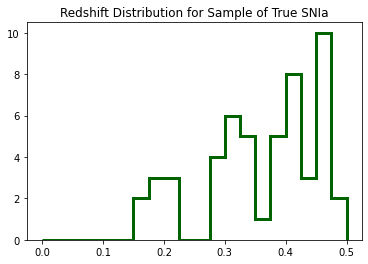

In [4]:
plt.hist(myTruthTable['redshift'], bins=20, range=(0.0,0.50), lw=3, histtype='step', color='darkgreen')
plt.title('Redshift Distribution for Sample of True SNIa')
plt.show()

## Retrieve all the diaObjects from that same region

In [5]:
results = service.search("SELECT ra, decl, diaObjectId, nDiaSources, "
                         "scisql_fluxToAbMag(rPSFluxMean/1e32) AS rPSMagMean, "
                         "scisql_fluxToAbMag(rPSFluxMax/1e32) AS rPSMagMin "
                         "FROM dp02_test_PREOPS863_00.DiaObject "\
                         "WHERE CONTAINS(POINT('ICRS', ra, decl), CIRCLE('ICRS', 57.5, -36.5, 0.3)) = 1 ", maxrec=100000)
myDiaObjs = results.to_table()
print(len(myDiaObjs))
del results

13483


## Match true SNIa and diaObjects

Show all diaObjects within 5", and record as a match if diaObject is within 1".

In [6]:
# make a place to stash matches between true SNIa and diaObjects
myTruthTable_diaObjectId = np.zeros(len(myTruthTable), dtype='int' )

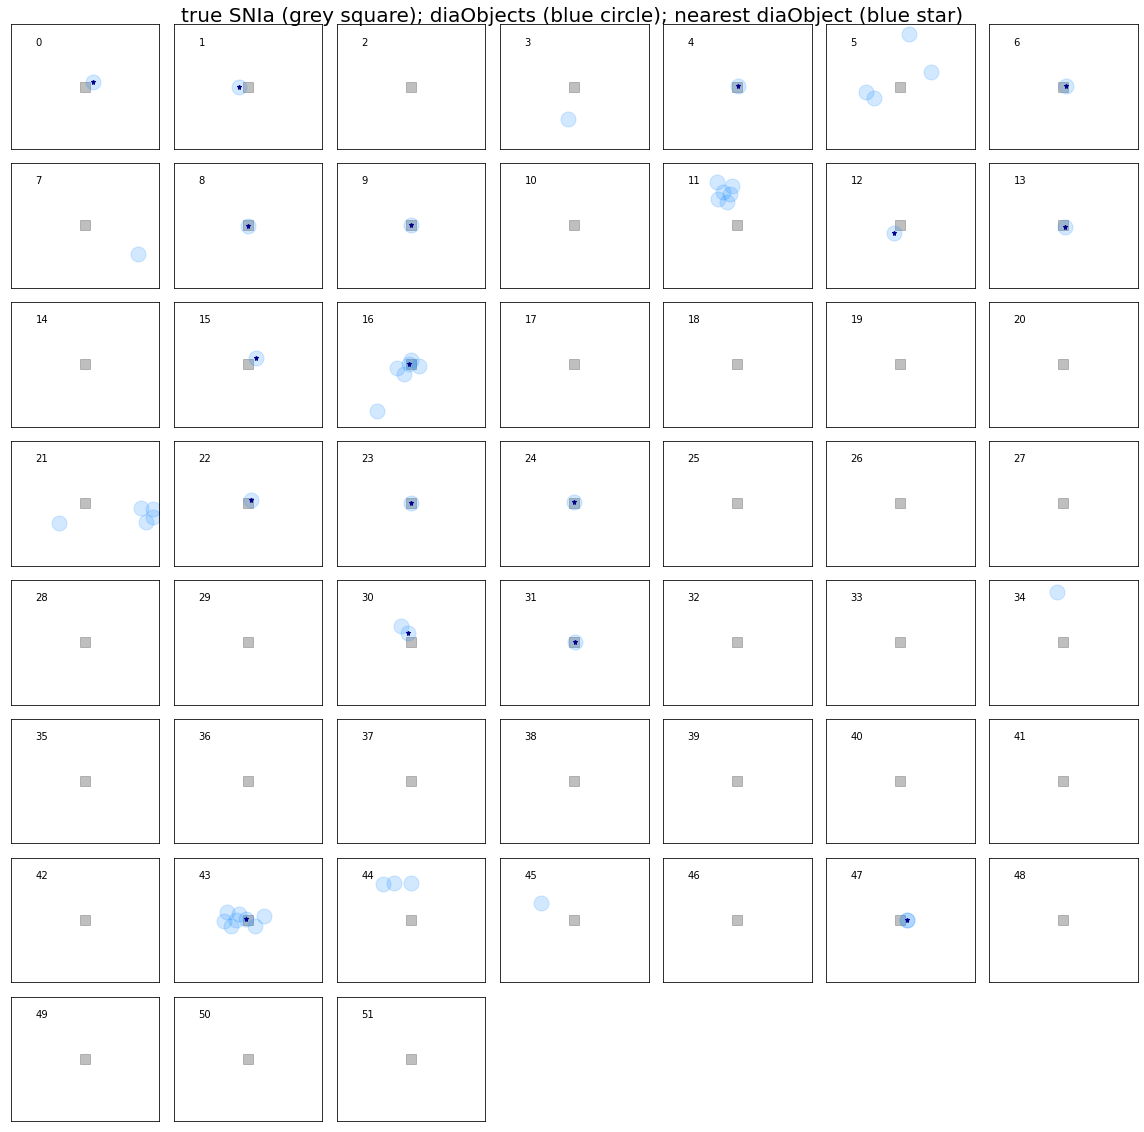

In [7]:
fig, ax = plt.subplots( 8, 7, figsize=(16,16) )

p = 0
s = 5.0 / 3600.0

for i in range(8):
    for j in range(7):
        if p < len(myTruthTable):
            
            # plot the truth SNIa location
            xval = myTruthTable['ra'][p]
            yval = myTruthTable['dec'][p]
            ax[i,j].plot(xval, yval, 's', ms=10, alpha=0.5, color='grey')
            ax[i,j].text(xval-s/1.5, yval+s/1.5, str(p))
            
            # plot nearby diaObjects
            tx = np.where((np.abs(myDiaObjs['ra'] - xval) < s) & (np.abs(myDiaObjs['decl'] - yval) < s))[0]
            if len(tx) > 0:
                ax[i,j].plot(myDiaObjs['ra'][tx], myDiaObjs['decl'][tx], 'o', ms=15, alpha=0.2, color='dodgerblue')
            
                # match to nearest my DiaObjs
                seps = np.sqrt((myDiaObjs['ra'][tx] - xval)**2 + (myDiaObjs['decl'][tx] - yval)**2)
                if np.min(seps) < 1.0/3600.0:
                    x = np.argmin(seps)
                    myTruthTable_diaObjectId[p] = myDiaObjs['diaObjectId'][tx[x]]
                    ax[i,j].plot(myDiaObjs['ra'][tx[x]], myDiaObjs['decl'][tx[x]], '*', ms=5, alpha=1, color='darkblue')
                    del x
            del tx
            
            # set plot style
            ax[i,j].set_xlim([xval-s,xval+s])
            ax[i,j].set_ylim([yval-s,yval+s])
            ax[i,j].xaxis.set_visible(False)
            ax[i,j].yaxis.set_visible(False)
            
            # increment truth index
            p += 1
        else:
            ax[i,j].axis('off')

plt.suptitle('true SNIa (grey square); diaObjects (blue circle); nearest diaObject (blue star)', fontsize=20)
plt.tight_layout()
plt.show()

## Plot diaSource lightcurves for the true SNIa matched to a diaObject

In [8]:
# index just the matches
tx = np.where(myTruthTable_diaObjectId != 0)[0]
print(len(tx))

17


In [9]:
# set up for plotting different filter data
filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
filter_color = ['darkviolet', 'darkgreen', 'red', 'darkorange', 'brown', 'black']
filter_symbol = ['o', '^', 'v', 's', '*', 'p']

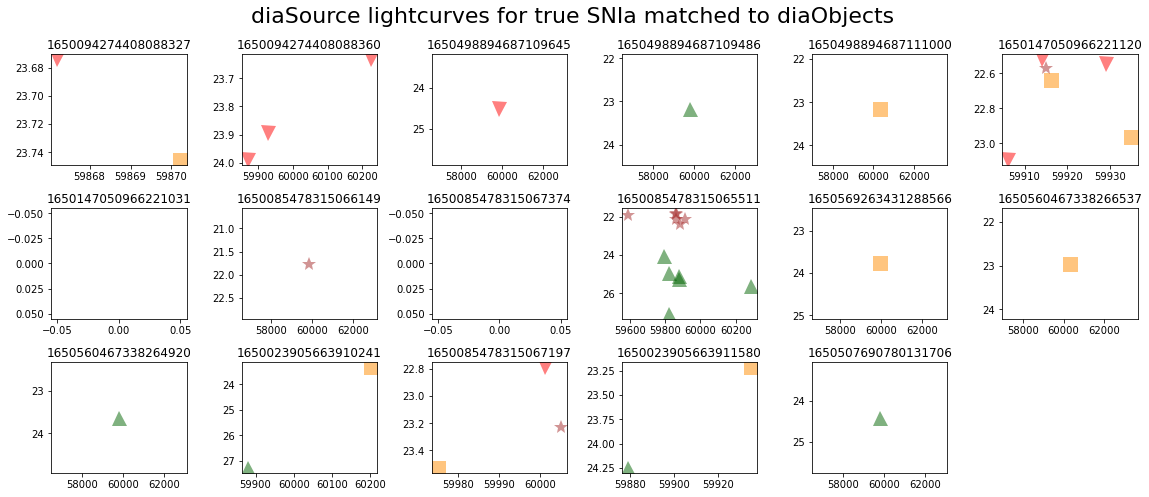

In [10]:
# use x to increment over tx, the matches
x = 0

fig, ax = plt.subplots( 3, 6, figsize=(16,7) )
for i in range(3):
    for j in range(6):
        if x < len(tx):
            
            # get all the diaSources for this matched diaObject
            results = service.search("SELECT ra, decl, diaObjectId, diaSourceId, "
                                     "filterName, midPointTai, "
                                     "scisql_fluxToAbMag(psFlux/1e32) AS psAbMag "
                                     "FROM dp02_test_PREOPS863_00.DiaSource "
                                     "WHERE diaObjectId = "+str(myTruthTable_diaObjectId[tx[x]]))
            myDiaSrc = results.to_table()

            # plot for each filter
            for f, filt in enumerate(filter_names):
                fx = np.where(myDiaSrc['filterName'] == filt)[0]
                ax[i,j].plot(myDiaSrc['midPointTai'][fx], myDiaSrc['psAbMag'][fx], 
                           filter_symbol[f], ms=15, mew=0, alpha=0.5, color=filter_color[f])
                del fx
            
            # set plot style
            ax[i,j].invert_yaxis()
            ax[i,j].set_title(str(myTruthTable_diaObjectId[tx[x]]))

            # increment
            x += 1
        
        else:
            ax[i,j].axis('off')

plt.suptitle('diaSource lightcurves for true SNIa matched to diaObjects', fontsize=22)
plt.tight_layout()
del x

<br>

From above, we can see that only diaObject 1650147050966221120 has a SNIa-like light curve.

From below, we can see that this truth SNIa is at low redshift. 

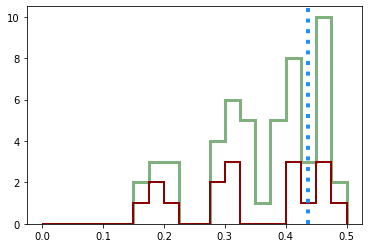

The one true SNIa with a transient-like lightcurve is at redshift:  0.44


In [11]:
plt.hist(myTruthTable['redshift'], bins=20, range=(0.0,0.50), lw=3, alpha=0.5, histtype='step', color='darkgreen')
plt.hist(myTruthTable['redshift'][tx], bins=20, range=(0.0,0.50), lw=2, alpha=1, histtype='step', color='darkred')

x = np.where(myTruthTable_diaObjectId[tx] == 1650147050966221120)[0]
plt.axvline(myTruthTable['redshift'][tx[x]], lw=4, ls='dotted', color='dodgerblue')

plt.show()
         
print('The one true SNIa with a transient-like lightcurve is at redshift: ', np.round(float(myTruthTable['redshift'][tx[x]]), 2))
del x,tx

It's peak brightness is about 22.5 mag in r.

At a redshift of 0.44, the distance modulus is ~41.95 mag. 

We expect SNIa at z=0.44 to have a peak brightness of about -19 + 41.95 = 22.95 mag, so yup that's close enough for ignoring filter corrections etc.